In [1]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt

rcParams = {'font.size': 20, 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}

plt.rcParams.update(rcParams)

def Breadth_of_Coverage(group):
    length = group.iloc[0]['SLen']
    cov = np.zeros(length)
    starts = group['SStart'].tolist()
    ends = group['SEnd'].tolist()
    for i in range(0, len(starts)):
        cov[starts[i]:ends[i]]=1
    return cov.sum()/length*100.0

def Load_PAF(filepath, filter_thresh = 90.0):
    try:
        lines = open(filepath).readlines()
        header = ['Query','Qlen','QStart','QEnd','Orientation','Subject','SLen',
                  'SStart','SEnd','Matches','AlignLength','MAPQ']
        op = []
        for l in lines:
            l = l.split('\t')[:12]
            op.append(dict(zip(header, l)))
        df = pd.DataFrame(op)
        df[['Qlen','QStart','QEnd','SLen','SStart',
            'SEnd','Matches','AlignLength','MAPQ']] = df[['Qlen','QStart','QEnd','SLen','SStart',
                                                          'SEnd','Matches','AlignLength','MAPQ']].astype('int')
        df['PIdent'] = df['Matches']/df[['Qlen','SLen']].min(axis = 1)*100
        df = df[df['PIdent'] >= filter_thresh]
        df = df.loc[df.groupby(['Query'])['PIdent'].idxmax()]
        
        return df
    except KeyError:
        return pd.DataFrame()
    


In [2]:
data_path = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/Mapping_Novel_Contigs_Single_Cell_June2022/'
files = listdir(data_path)
df_alignments = pd.DataFrame()
for f in files:
    if f.endswith(".paf"):
        df = Load_PAF(data_path+f, 95.0)
        if len(df) <= 0:
            continue
        df_stats = pd.DataFrame()
        df_stats['Breadth_Coverage'] = df.groupby('Subject').apply(Breadth_of_Coverage)
        df_stats['Avg-PIdent'] = df.groupby('Subject').mean()['PIdent']
        df_stats['Single_Cell_Sample'] = f.replace("_FD_mapped_to_novel.paf","")
        df_stats = df_stats.reset_index()
        df_alignments = df_alignments.append(df_stats, ignore_index = True)
        print(f)


UncmicOcRedA02K9_FD.paf
UncmicOcRedA3I13_FD.paf
UncmicMusRedA1H3_FD.paf
UncmicORedA02J10_FD.paf
UncmicOctRedA3D3_FD.paf
UncmicMRedA02N14_2_FD.paf
UncmicMRedA02L14_2_FD.paf
UncmicMusRedA1D3_FD.paf
UncmicOcRedA02G9_FD.paf
UncmicORedA01E14_FD.paf
UncmicOcRedA2H13_FD.paf
UncmicMusRedA1G6_FD.paf
UncmicMRedA02K12_2_FD.paf
UncmicOcRedA1E20_FD.paf
UncmicMusRedA1D3_2_FD.paf
UncmicOcRedA2E16_FD.paf
UncmicORedA02L17_FD.paf
UncmicOcRedA01C8_FD.paf
UncmicOcRedA3G12_FD.paf
UncmicMuRedA1J20_FD.paf
UncmicOcRedA1K15_FD.paf
UncmicMuRedA1H18_FD.paf
UncmicORedA02C18_FD.paf
UncmicORedA01J19_FD.paf
UncmicORedA02H17_FD.paf
UncmicOcRedA3J21_FD.paf
UncmicOcRedA3G19_FD.paf
UncmicOcRedA3C21_FD.paf
UncmicORedA02I19_FD.paf
UncmicOcRedA3I19_FD.paf
UncmicMRedA02H22_FD.paf
UncmicORedA02D10_FD.paf
UncmicOctRedA2K7_FD.paf
UncmicMRedA02H20_FD.paf
UncmicOcRedA3D10_FD.paf
UncmicMuRedA1H10_FD.paf
UncmicMRedA02D15_3_FD.paf
UncmicOcRedA1K18_FD.paf
UncmicMusRedA1C6_FD.paf
UncmicOcRedA3F15_FD.paf
UncmicMRedA02F22_2_FD.paf
Uncm

In [5]:
df_groups = pd.read_csv('/Users/harihara/Research-Activities/Data/Hot-Spring/contig_containment_groups_subset_June_2022.txt',
                        sep = "\t")
df_groups = df_groups[['GroupID','RepresentativeContig']]
df_groups = df_groups.set_index(['RepresentativeContig'])
df_groups = df_groups.drop_duplicates()

df_filtered_alignments = df_alignments[df_alignments['Breadth_Coverage'] > 95]

df_grp = df_filtered_alignments.groupby('Subject').count()[['Single_Cell_Sample']]
df_grp = df_grp.join(df_groups, how = 'inner')
df_grp = df_grp.set_index('GroupID')
df_grp['Single_Cell_Sample'] = df_grp['Single_Cell_Sample'].fillna(0)
df_grp = df_grp.sort_values(by = 'Single_Cell_Sample', ascending = False)

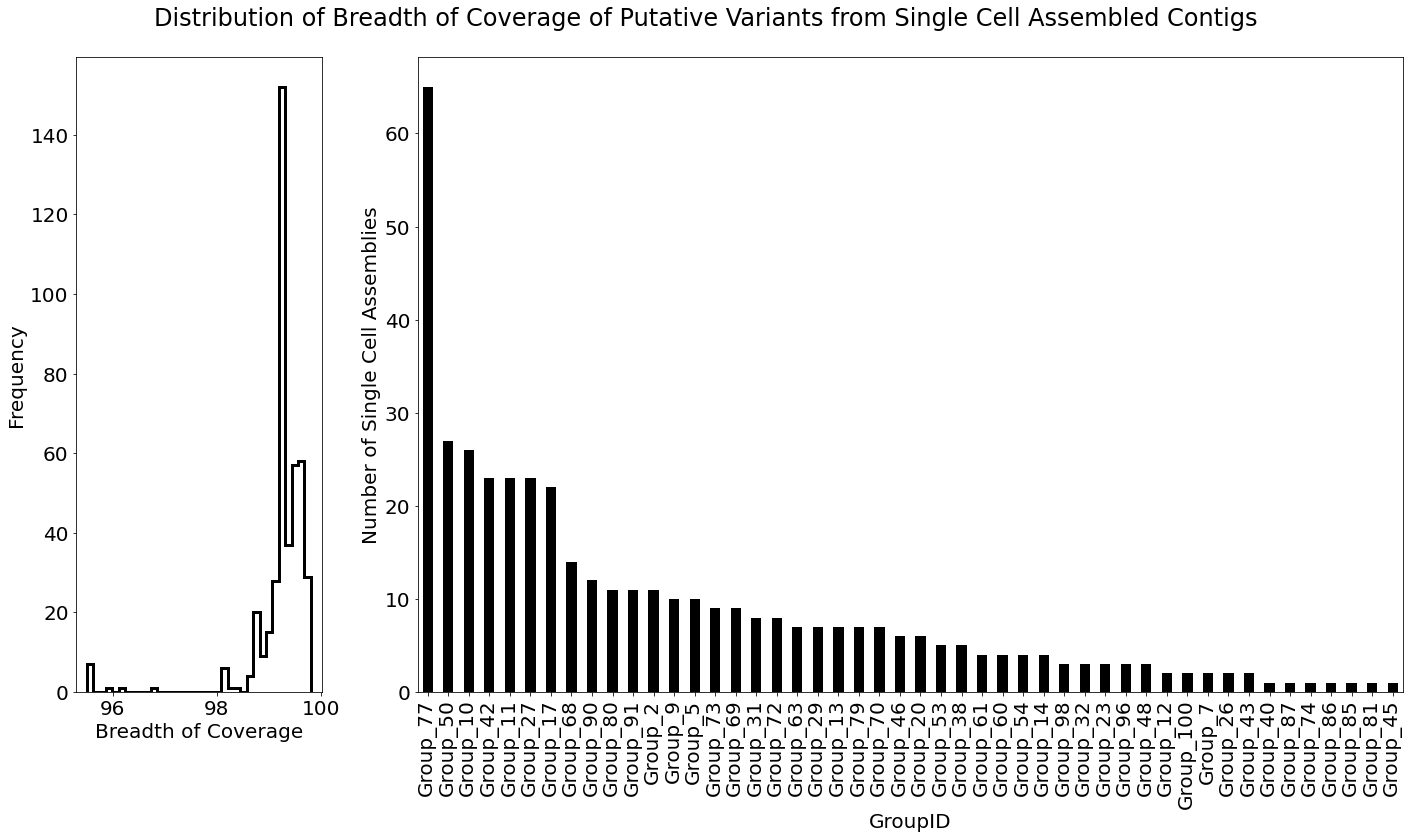

In [6]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,2,figsize = (20,12), gridspec_kw={'width_ratios': [0.75, 3]})
df_filtered_alignments[['Breadth_Coverage']].plot(kind = 'hist', bins = 35, ax = ax[0], histtype='step',
                                                  linewidth=3, legend = False, color = 'black')
fig.suptitle('Distribution of Breadth of Coverage of Putative Variants from Single Cell Assembled Contigs')
ax[0].set_xlabel('Breadth of Coverage')


df_grp.plot(kind = 'bar', ax = ax[1], legend = False,color = 'black')
ax[1].set_ylabel('Number of Single Cell Assemblies')
fig.tight_layout()

#fig.savefig('/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/Synechococcus-Paper/Breadth-Dist.pdf')